In [1]:
import h_transport_materials as htm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

/opt/anaconda3/envs/festim2-env/lib/python3.13/site-packages/pybtex/plugin/__init__.py:26: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
# filter only tungsten and H
diffusivities = htm.diffusivities.filter(material="316l_steel").filter(isotope="h")
permeabilities = htm.permeabilities.filter(material="316l_steel").filter(isotope="h")

In [3]:
# --- Edit this path ---
csv_path = "results/figs/316l_steel_diffusivities.csv"

# Read CSV
df = pd.read_csv(csv_path)

# Ensure numeric types and drop rows missing needed values
for col in ["Temperature (K)", "Diffusivity", "Permeability"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")
df = df.dropna(subset=["Temperature (K)", "Diffusivity", "Permeability"])

# Sort by temperature so the connecting line is meaningful
df = df.sort_values("Temperature (K)")

T = df["Temperature (K)"].values
D = df["Diffusivity"].values
Phi = df["Permeability"].values

In [5]:
invT = 1.0 / T  # 1/T axis

print(invT, np.log(D), 1)

# Fit log(D) = a*(1/T) + b
D_coeffs = np.polyfit(invT, np.log(D), 1)

# Generate fit line only across the range of your data
D_invT_fit = np.linspace(invT.min(), invT.max(), 200)
D_fit = np.exp(D_coeffs[0] * D_invT_fit +D_coeffs[1])


# Fit log(D) = a*(1/T) + b
Phi_coeffs = np.polyfit(invT, np.log(Phi), 1)

# Generate fit line only across the range of your data
Phi_invT_fit = np.linspace(invT.min(), invT.max(), 200)
Phi_fit = np.exp(Phi_coeffs[0] * Phi_invT_fit +Phi_coeffs[1])

[] [] 1


TypeError: expected non-empty vector for x

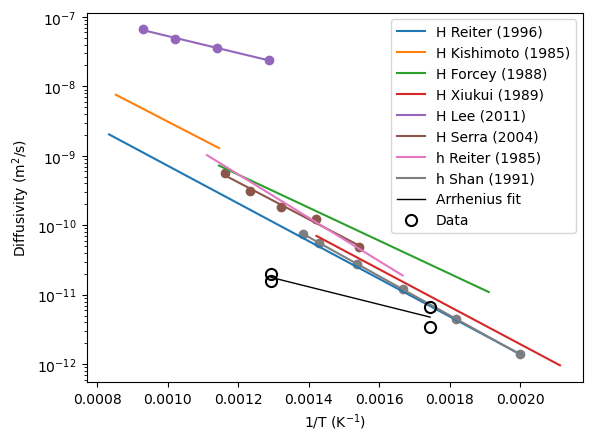

In [ ]:
# plot the properties
htm.plotting.plot(diffusivities)

# Overlay Arrhenius fit line
plt.plot(D_invT_fit, D_fit, "k-", linewidth=1, label="Arrhenius fit")

# Overlay measured points as big black circles
plt.plot(invT, D, "ko", markersize=8, markeredgewidth=1.5, markerfacecolor="none", label="Data")

plt.yscale("log")
plt.ylabel("Diffusivity (m$^2$/s)")
plt.legend()
plt.show()

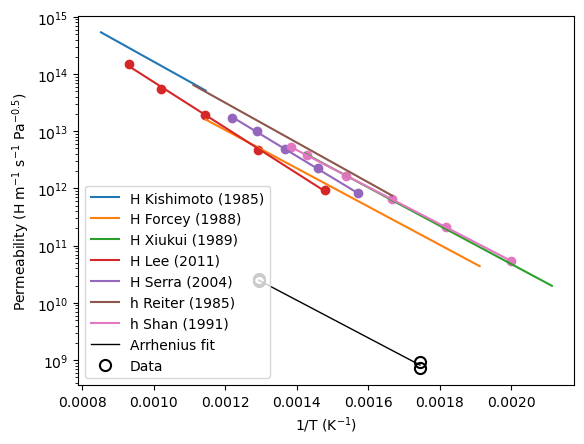

In [ ]:
htm.plotting.plot(permeabilities)

# Overlay Arrhenius fit line
plt.plot(Phi_invT_fit, Phi_fit, "k-", linewidth=1, label="Arrhenius fit")

# Overlay measured points as big black circles
plt.plot(invT, Phi, "ko", markersize=8, markeredgewidth=1.5, markerfacecolor="none", label="Data")

plt.yscale("log")
plt.ylabel("Permeability (H m$^{-1}$ s$^{-1}$ Pa$^{-0.5}$)")
plt.yscale("log")
plt.legend()
plt.show()